# **Recommendation System**

## Deskripsi Proyek


Kemajuan teknologi digital telah membuka akses luas ke konten film, namun juga menimbulkan tantangan bagi pengguna untuk memilih film yang sesuai. Sistem rekomendasi film hadir sebagai solusi untuk membantu pengguna menemukan film yang relevan dengan preferensi mereka.

Dataset diambil dari [https://grouplens.org/datasets/movielens/100k/]

In [1]:
# Langkah 1: Unduh file zip dari URL
!wget -O ml-latest-small.zip https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

# Langkah 2: Unzip file
!unzip ml-latest-small.zip

--2025-04-27 09:10:01--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.35MB/s    in 0.2s    

2025-04-27 09:10:01 (4.35 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Import Library

In [2]:
!pip install surprise scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505213 sha256=0bd78279d0638644b0ec1dc2d3476b352e096a16796a86125ba3363bbc9fdee9
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Understanding

### Gathering Data


In [3]:
links = pd.read_csv('/content/ml-latest-small/links.csv')
movies = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
tags = pd.read_csv('/content/ml-latest-small/tags.csv')
display(links.head(), links.shape, movies.head(), movies.shape, ratings.head(), ratings.shape, tags.head(), tags.shape)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9742, 3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


(9742, 3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


(100836, 4)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


(3683, 4)

### Assessing Data

#### Checking Missing Value


In [4]:
display(links.isnull().sum(), movies.isnull().sum(), ratings.isnull().sum(), tags.isnull().sum())

,0
movieId,0
imdbId,0
tmdbId,8


,0
movieId,0
title,0
genres,0


,0
userId,0
movieId,0
rating,0
timestamp,0


,0
userId,0
movieId,0
tag,0
timestamp,0


#### Checking Duplicate Data


In [5]:
display(links.duplicated().sum(), movies.duplicated().sum(), ratings.duplicated().sum(), tags.duplicated().sum())

0

0

0

0

### Cleaning Data

### Exploratory Data Analysis (EDA)

#### Unique Value

##### Mengecek nilai unique untuk userid, movieid

In [6]:
display(movies.movieId.nunique(), ratings.userId.nunique(), tags.userId.nunique(),
         tags.tag.nunique(), movies.genres.nunique())

9742

610

58

1589

951

##### Mengecek nilai unique genre

In [7]:
genres_split = movies.genres.str.split('|', expand=True)
genres_split.stack().unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

##### Mengecek value counts tiap genre

In [8]:
genres_split = movies.genres.str.split('|').explode()
genre_counts = genres_split.value_counts()
genre_counts

,count
genres,
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978


#### Wordcloud

##### Inisiasi fungsi wordcloud

In [9]:
from wordcloud import WordCloud

def wordcloud(data, title):
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

##### Wordcloud tags

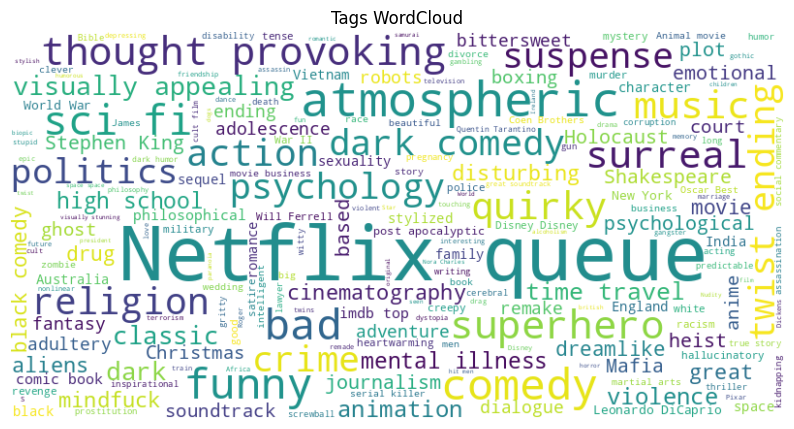

In [10]:
wordcloud(tags.tag, 'Tags WordCloud')

##### Wordcloud untuk Genre

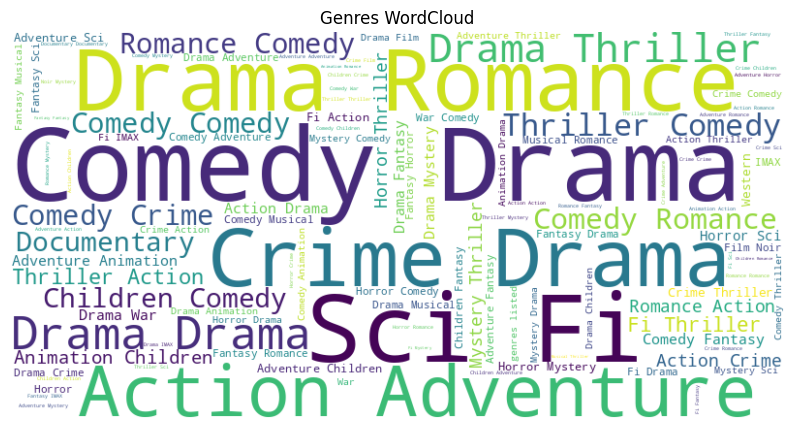

In [11]:
wordcloud(genres_split, 'Genres WordCloud')

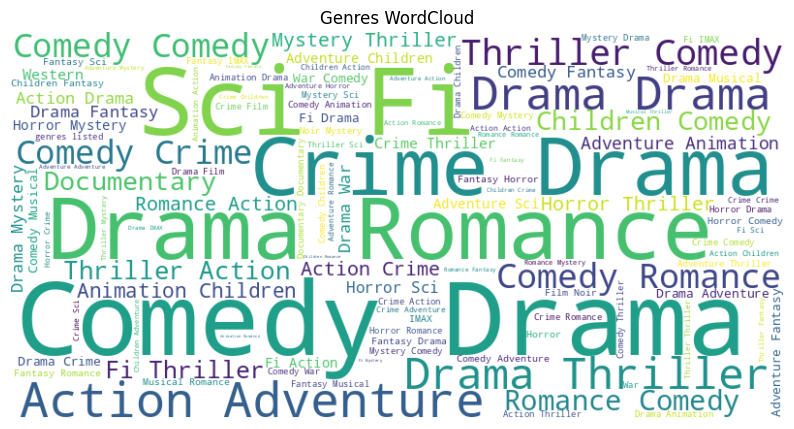

In [12]:
wordcloud(movies.genres, 'Genres WordCloud')

#### Film berdasarkan Rating

In [13]:
display(movies.head(), ratings.head(), tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


##### Menggabung data movies dan ratings

In [14]:
movies_ratings = pd.merge(movies, ratings, on='movieId')
display(movies_ratings.head(), movies_ratings.shape)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


(100836, 6)

#### Rata rata rating terendah film

In [15]:
movies_ratings.groupby('title')['rating'].mean().sort_values(ascending=True).head(10)

,rating
title,
Rust and Bone (De rouille et d'os) (2012),0.5
The Emoji Movie (2017),0.5
The Butterfly Effect 3: Revelations (2009),0.5
"Follow Me, Boys! (1966)",0.5
The Beast of Hollow Mountain (1956),0.5
Dead of Night (1945),0.5
Maria Bamford: The Special Special Special! (2012),0.5
"Haunted House 2, A (2014)",0.5
Midnight Chronicles (2009),0.5


#### Rata rata rating tertinggi film


In [16]:
movies_ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


#### Film yang paling banyak diberi rating

<Axes: xlabel='title'>

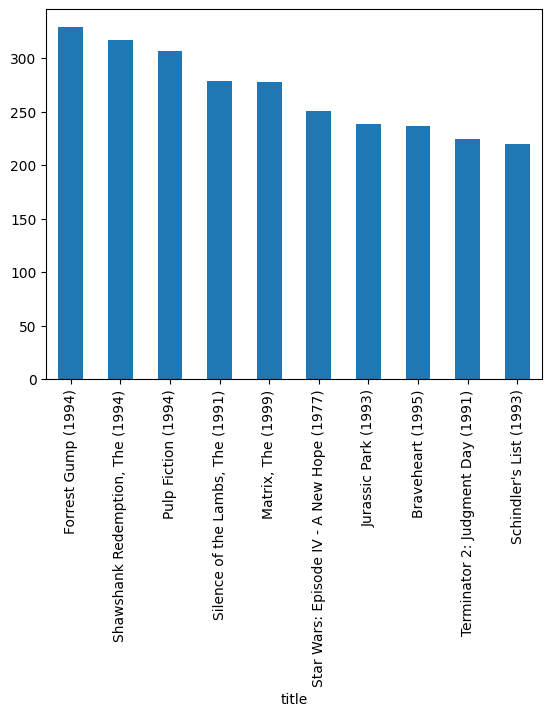

In [17]:
movies_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(10).plot(kind='bar')

## Data Preparation

### General Data Preparation

Mengubah tipe data kolom timestamp menjadi datetime

In [18]:
tags.timestamp = pd.to_datetime(tags.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
display(tags.head(), ratings.head())

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


Menggabung data movies dengan links

In [19]:
movies_full = pd.merge(movies, links, on='movieId')
display(movies_full.head(), movies_full.shape, movies_full.isnull().sum())

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


(9742, 5)

,0
movieId,0
title,0
genres,0
imdbId,0
tmdbId,8


In [20]:
links[links.tmdbId.isnull()]

,movieId,imdbId,tmdbId
624,791,113610,NaN
843,1107,102336,NaN
2141,2851,81454,NaN
3027,4051,56600,NaN
5532,26587,92337,NaN
5854,32600,377059,NaN
6059,40697,105946,NaN
7382,79299,874957,NaN


Membuang baris yang terdapat nilai kosong (null)

In [21]:
links.dropna(inplace=True)
display(links.head(),links.shape, links.isnull().sum())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9734, 3)

,0
movieId,0
imdbId,0
tmdbId,0


Membersihkan tahun rilis judul film  

In [22]:
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '',
                                                        regex=True).str.strip()
movies['title'] = movies['title'].str.replace(r'\(\d{4}(–\d{4})?\)', '',
                                                        regex=True).str.strip()
display(movies, movies.isnull().sum())

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy
9739,193585,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation


,0
movieId,0
title,0
genres,0


Membersihkan kolom genres dengan menghapus karakter

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')

movies['genres'] = movies['genres'].str.replace(r"[\[\]']", "", regex=True).str.replace("|", " ")

movies['features'] = movies['title'] + " " + movies['genres']
movies

,movieId,title,genres,features
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,Toy Story Adventure Animation Children Comedy ...
1,2,Jumanji,Adventure Children Fantasy,Jumanji Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance,Grumpier Old Men Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance,Waiting to Exhale Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy,Father of the Bride Part II Comedy
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action Animation Comedy Fantasy,Black Butler: Book of the Atlantic Action Anim...
9738,193583,No Game No Life: Zero,Animation Comedy Fantasy,No Game No Life: Zero Animation Comedy Fantasy
9739,193585,Flint,Drama,Flint Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action Animation,Bungo Stray Dogs: Dead Apple Action Animation


### Data Preparation untuk Modelling Content Based Filtering

Mengubah fitur judul film menjadi matriks TF-IDF, lalu menghitung kesamaan antarfilm menggunakan cosine similarity untuk mendapatkan nilai kemiripan setiap film satu sama lain.

In [24]:
tfidf_matrix = tfidf.fit_transform(movies['features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.2574009 , 0.02187374, ..., 0.        , 0.06022487,
        0.0125025 ],
       [0.2574009 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02187374, 0.        , 1.        , ..., 0.        , 0.        ,
        0.0112517 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06022487, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.0125025 , 0.        , 0.0112517 , ..., 0.        , 0.        ,
        1.        ]])

### Data Preparation untuk Modelling Collaborative Filtering

Membagi data menjadi train dan test, lalu menghitung RMSE dan MAE untuk evaluasi akurasi model.

In [25]:
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Model Development

## Content Based Filtering

Membuat fungsi untuk merekomendasikan 10 film mirip berdasarkan kesamaan judul yang diberikan, menggunakan cosine similarity.

In [26]:
# Fungsi untuk rekomendasi film (Content Based Filtering menggunakan Cosine Similarity)
def recommend_movies(title, cosine_sim=cosine_sim):

    idx = movies[movies['title'] == title].index[0]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return movies.iloc[movie_indices][['movieId','title', 'genres']]

Kode ini akan menampilkan 10 rekomendasi film yang mirip dengan "Jumanji" berdasarkan kesamaan konten film.

In [27]:
recommend_movies("Jumanji")

,movieId,title,genres
9636,179401,Jumanji: Welcome to the Jungle,Action Adventure Children
7039,68954,Up,Adventure Animation Children Drama
6194,45074,"Wild, The",Adventure Animation Children Comedy Fantasy
8800,130450,Pan,Adventure Children Fantasy
7108,70697,G-Force,Action Adventure Children Fantasy
5396,9004,D.A.R.Y.L.,Adventure Children Sci-Fi
3568,4886,"Monsters, Inc.",Adventure Animation Children Comedy Fantasy
26,27,Now and Then,Children Drama
5473,26198,"Yours, Mine and Ours",Children Comedy
5777,31422,Are We There Yet?,Children Comedy


Menampilkan 10 rekomendasi film yang mirip dengan "Toy Story" berdasarkan kesamaan konten film.

In [28]:
recommend_movies("Toy Story")

,movieId,title,genres
2355,3114,Toy Story 2,Adventure Animation Children Comedy Fantasy
7355,78499,Toy Story 3,Adventure Animation Children Comedy Fantasy IMAX
3595,4929,"Toy, The",Comedy
2539,3400,We're Back! A Dinosaur's Story,Adventure Animation Children Fantasy
2227,2961,"Story of Us, The",Comedy Drama
4089,5843,Toy Soldiers,Action Drama
7039,68954,Up,Adventure Animation Children Drama
1617,2161,"NeverEnding Story, The",Adventure Children Fantasy
1570,2108,L.A. Story,Comedy Romance
6194,45074,"Wild, The",Adventure Animation Children Comedy Fantasy


Fungsi-fungsi untuk menghitung metrik evaluasi untuk sistem rekomendasi

In [29]:
def precision_recall_content_based(input_movie, recommended_movies, k=10):
    input_tfidf = tfidf.transform([input_movie])
    rec_tfidf = tfidf.transform(recommended_movies)

    sim_scores = cosine_similarity(input_tfidf, rec_tfidf)[0]
    precision = sum(sim_scores[:k]) / k
    recall = sum(sim_scores[:k]) / sum(sim_scores) if sum(sim_scores) > 0 else 0
    return precision * 100, recall * 100

input_movies = ["Toy Story", "Jumanji"]
recommendation_results = {movie: list(recommend_movies(movie)['title']) for movie in input_movies}

for movie in input_movies:
    recommended_titles = recommendation_results[movie]
    precision, recall = precision_recall_content_based(movie, recommended_titles, k=5)
    print(f"Precision@5 for '{movie}': {precision:.2f}%")
    print(f"Recall@5 for '{movie}': {recall:.2f}%")

Precision@5 for 'Toy Story': 74.06%
Recall@5 for 'Toy Story': 71.55%
Precision@5 for 'Jumanji': 12.85%
Recall@5 for 'Jumanji': 100.00%


## Collaborative Filtering

In [30]:
from surprise.model_selection import train_test_split
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse, mae

Melatih model SVD untuk rekomendasi film

In [31]:
model = SVD()

model.fit(trainset)

predictions = model.test(testset)
print("Root Mean Squared Error (RMSE):", rmse(predictions))
print("Mean Absolute Error (MAE):", mae(predictions))

RMSE: 0.8795
Root Mean Squared Error (RMSE): 0.8794858964349299
MAE:  0.6765
Mean Absolute Error (MAE): 0.6764787431276184


Fungsi ini merekomendasikan 10 film teratas yang belum pernah ditonton oleh pengguna berdasarkan prediksi rating model.

In [32]:
def get_recommendations(user_id, movies_df, top_n=10):
    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    all_movie_ids = movies_df['movieId'].unique()
    unrated_movie_ids = np.setdiff1d(all_movie_ids, user_rated_movies)

    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)

    recommended_movie_ids = [pred.iid for pred in predictions[:top_n]]
    recommendations = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    return recommendations[['title', 'genres']]

Rekomendasi film untuk user id 331

In [33]:
get_recommendations(331, movies)

,title,genres
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy War
828,Reservoir Dogs,Crime Mystery Thriller
902,Aliens,Action Adventure Horror Sci-Fi
903,"Good, the Bad and the Ugly, The (Buono, il bru...",Action Adventure Western
905,12 Angry Men,Drama
906,Lawrence of Arabia,Adventure Drama War
909,Apocalypse Now,Action Drama War
922,"Godfather: Part II, The",Crime Drama
1939,"Matrix, The",Action Sci-Fi Thriller
4581,Monty Python's The Meaning of Life,Comedy


Rekomendasi film untuk user id 1

In [34]:
user_id = 1
recommended_movies = get_recommendations(user_id, movies)
print("Recommended Movies for User", user_id)
print(recommended_movies)

Recommended Movies for User 1
                                                 title  \
602  Dr. Strangelove or: How I Learned to Stop Worr...   
680                            Philadelphia Story, The   
686                                        Rear Window   
690                                 North by Northwest   
694                                         Casablanca   
841                          Streetcar Named Desire, A   
878            Cinema Paradiso (Nuovo cinema Paradiso)   
896                    One Flew Over the Cuckoo's Nest   
903  Good, the Bad and the Ugly, The (Buono, il bru...   
906                                 Lawrence of Arabia   

                                        genres  
602                                 Comedy War  
680                       Comedy Drama Romance  
686                           Mystery Thriller  
690  Action Adventure Mystery Romance Thriller  
694                              Drama Romance  
841                                  